Pick up where I left off...

# Data

Previous modeling effort processed data in notebook `b_/00c`, saved each market's data as a pickle file. Then, when it came time to EDA, modeling -- just read in a .pkl file

Now, the processing code in notebook `00c` is captured by script `preprocess.py`. So we just need to load that data, filter by market, and save a pickle file.

Do this using a script

In [1]:
import os
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

import datetime

from sklearn.model_selection import train_test_split

In [2]:
pd.options.mode.chained_assignment = None
pd.set_option("display.max_columns", 100)

## load and inspect

In [3]:
DATA_DIR = "/data/16/kendra.frederick/shopping_grid/output/market_pkl_files_take2/"

In [4]:
# !ls $DATA_DIR

JFK-LHR.pkl  LHR-JFK.pkl


In [4]:
market = "JFK-LHR"
filename = "{}.pkl".format(market)
df = pd.read_pickle(os.path.join(DATA_DIR, filename))

In [5]:
len(df)

1887402

In [6]:
df_no_dups = df.drop_duplicates()

In [7]:
len(df_no_dups)

152651

I don't know why there are so many duplicates

## helper funcs

In [8]:
def plot_min_fare(market_pdf, dd, rd, market):
    trip_df = market_pdf[(market_pdf['outDeptDt'] == dd) & (market_pdf['inDeptDt'] == rd)]
    trip_df.sort_values(by='searchDt_dt', inplace=True)
    plt.figure(figsize=(12,5))
    plt.plot(-trip_df['days_til_dept'], trip_df['min_fare'], marker='o')
    plt.xlabel("advanced purchase days")
    plt.ylabel('min fare (USD)')
    plt.title(f"{market} - depart {dd} - return {rd}");

# train-test split 

prior to EDA

In [38]:
df_no_dups.head()

,market,origin,destination,round_trip,pos,currency,outDeptDt,inDeptDt,shop_counts,min_fare,origin_country,origin_city,destination_country,destination_city,outDeptDt_dt,inDeptDt_dt,searchDt_dt,days_til_dept,stay_duration,shop_ind,searchDt
0,JFK-LHR,JFK,LHR,1,US,USD,20221221,20230111,17,919.68,US,NYC,GB,LON,2022-12-21,2023-01-11,2022-11-05,46,21.0,1,20221105
1,JFK-LHR,JFK,LHR,1,US,USD,20221204,20221216,14,557.78,US,NYC,GB,LON,2022-12-04,2022-12-16,2022-11-05,29,12.0,1,20221105
2,JFK-LHR,JFK,LHR,1,US,USD,20221228,20230103,349,817.48,US,NYC,GB,LON,2022-12-28,2023-01-03,2022-11-05,53,6.0,1,20221105
3,JFK-LHR,JFK,LHR,1,US,USD,20221208,20221216,62,547.08,US,NYC,GB,LON,2022-12-08,2022-12-16,2022-11-05,33,8.0,1,20221105
4,JFK-LHR,JFK,LHR,1,US,USD,20221112,20221115,167,544.78,US,NYC,GB,LON,2022-11-12,2022-11-15,2022-11-05,7,3.0,1,20221105


In [39]:
df_no_dups['round_trip'].value_counts()

1    143576
0      9075
Name: round_trip, dtype: int64

In [10]:
target_col = 'min_fare'
X = df_no_dups.drop(columns=[target_col])
y = df_no_dups[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=19)
train_pdf = pd.concat([X_train, y_train], axis=1)
train_pdf["train_test"] = "train"
X_test["train_test"] = "test"
mask_df = pd.concat([train_pdf, X_test], axis=0, sort=False)

# RT vs OW

In [41]:
df_rt = mask_df[mask_df['round_trip'] == 1].dropna(subset=[target_col])
df_ow = mask_df[mask_df['round_trip'] == 0].dropna(subset=[target_col])

In [42]:
len(df_rt)

129267

In [43]:
len(df_ow)

8118

## RT

In [19]:
data = df_rt['min_fare']

In [20]:
df_rt['min_fare'].describe()

count    129267.000000
mean        638.646034
std         315.253349
min          46.780000
25%         524.370000
50%         568.470000
75%         701.780000
max       18690.270000
Name: min_fare, dtype: float64

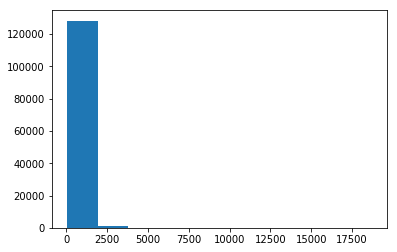

In [21]:
plt.hist(df_rt['min_fare']);

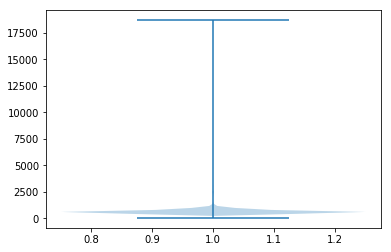

In [22]:
plt.violinplot(df_rt['min_fare']);

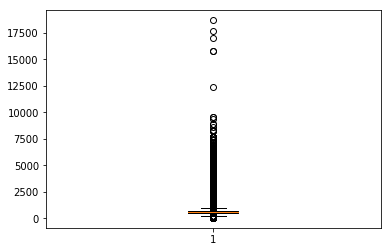

In [23]:
plt.boxplot(df_rt['min_fare']);

In [24]:
# # filter out anomalously high/low fares
# count_llim = data_params['count_llim']
# fare_ulim = np.percentile(data, market_configs["fare_ulim_percentile"])
# fare_llim = np.percentile(market_pdf[target_col], market_configs["fare_llim_percentile"])

for q in [0.1, 1, 5, 50, 95, 99, 99.9]:
    print(f"{q}%: {np.percentile(data, q)}")

0.1%: 85.2332
1%: 394.46600000000007
5%: 442.38
50%: 568.47
95%: 971.577
99%: 1314.173999999998
99.9%: 4792.819300000045


In [25]:
len(data)

129267

In [26]:
print("Lower q, value, num data less than")
for q in [0.1, 0.25, 0.5]:
    llim = np.percentile(data, q)
    toss_data = data[data <= llim]
    clipped_data = data[data>llim]
    print(f"{q}%, {llim:.0f}, {len(toss_data)}")

Lower q, value, num data less than
0.1%, 85, 130
0.25%, 372, 325
0.5%, 388, 702


In [27]:
print("Upper q, value, num data greater than")
for q in [99, 99.5, 99.75, 99.9]:
    ulim = np.percentile(data, q)
    toss_data = data[data >= ulim]
    clipped_data = data[data < ulim]
    print(f"{q}%, {ulim:.0f}, {len(toss_data)}")

Upper q, value, num data greater than
99%, 1314, 1293
99.5%, 2453, 647
99.75%, 2852, 324
99.9%, 4793, 130


In [28]:
lq = 0.5
uq = 99.5

llim = np.percentile(data, lq)
ulim = np.percentile(data, uq)

clip_rt_df = df_rt[df_rt['min_fare'].between(llim, ulim)]
len(clip_rt_df) / len(df_rt)

0.9907400960802061

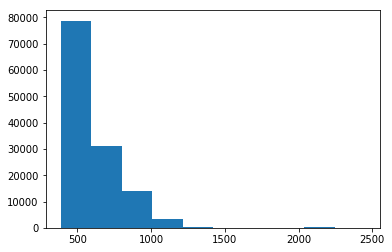

In [29]:
plt.hist(clip_rt_df['min_fare']);

Not a normal distribution, but less skewed than before

### ALT

In [30]:
med = np.percentile(data, 50)
med

568.47

In [31]:
med*3

1705.41

In [32]:
med*5

2842.3500000000004

In [33]:
med * 0.4

227.38800000000003

In [34]:
med * 0.5

284.235

## OW

In [44]:
df_ow['min_fare'].describe()

count    8118.000000
mean      324.813054
std        77.428299
min         4.500000
25%       295.800000
50%       296.500000
75%       330.900000
max       864.500000
Name: min_fare, dtype: float64

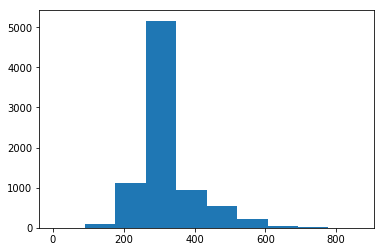

In [45]:
plt.hist(df_ow['min_fare']);

More normally distributed than RT fares

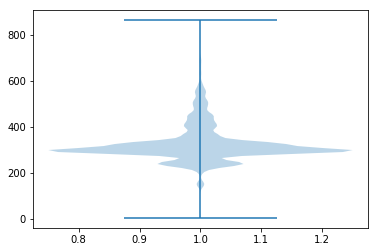

In [46]:
plt.violinplot(df_ow['min_fare']);

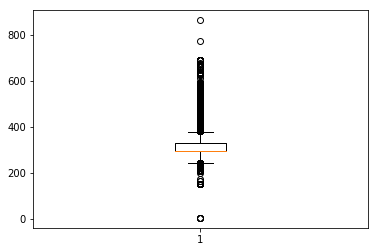

In [47]:
plt.boxplot(df_ow['min_fare']);

In [48]:
data = df_ow['min_fare']

In [49]:
for q in [0.1, 1, 5, 50, 95, 99, 99.9]:
    print(f"{q}%: {np.percentile(data, q)}")

0.1%: 150.8
1%: 150.8
5%: 239.9
50%: 296.5
95%: 498.8
99%: 578.53
99.9%: 692.4830000000007


In [50]:
len(data)

8118

In [51]:
print("Lower q, value, num data less than")
for q in [0.1, 0.25, 0.5]:
    llim = np.percentile(data, q)
    toss_data = data[data <= llim]
    clipped_data = data[data>llim]
    print(f"{q}%, {llim:.0f}, {len(toss_data)}")

Lower q, value, num data less than
0.1%, 151, 89
0.25%, 151, 89
0.5%, 151, 89


In [52]:
print("Upper q, value, num data greater than")
for q in [99, 99.5, 99.75, 99.9]:
    ulim = np.percentile(data, q)
    toss_data = data[data >= ulim]
    clipped_data = data[data < ulim]
    print(f"{q}%, {ulim:.0f}, {len(toss_data)}")

Upper q, value, num data greater than
99%, 579, 88
99.5%, 631, 44
99.75%, 669, 21
99.9%, 692, 9


In [53]:
data = df_ow['min_fare']
lq = 0.1
uq = 99.9

llim = np.percentile(data, lq)
ulim = np.percentile(data, uq)

clip_ow_df = df_ow[df_ow['min_fare'].between(llim, ulim)]
len(clip_ow_df) / len(df_ow)

0.9982754372998276

# EDA
focusing on OW. Less data, but more "well-behaved"

## by dtd

In [54]:
dtd_grp = clip_ow_df.groupby('days_til_dept').agg(
    {'min_fare': ['mean', 'std', np.median]}
)

dtd_grp.columns = ['avg_min_fare', 'std_min_fare', 'median_min_fare']
dtd_grp.reset_index(inplace=True)

dtd_grp.sort_values(by='days_til_dept', inplace=True)

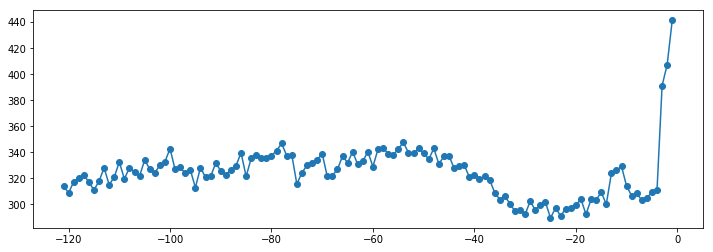

In [55]:
plt.figure(figsize=(12, 4))
plt.plot(-dtd_grp['days_til_dept'], dtd_grp['avg_min_fare'], marker='o');

In [56]:
dtd_grp.head(21)

,days_til_dept,avg_min_fare,std_min_fare,median_min_fare
0,1,441.455556,121.275757,420.60
1,2,407.289062,113.303631,389.80
2,3,391.181385,101.648130,361.00
3,4,310.915075,25.649352,296.40
4,5,309.345522,26.324736,296.30
5,6,305.061429,26.776993,296.20
6,7,303.128169,19.886357,296.20
7,8,308.462687,41.715577,296.20
8,9,306.647059,34.939327,296.20
9,10,313.980645,68.835460,296.20


Roughly: anything 4 days & out is "same", and within 3 days is: WTFK

In [57]:
clip_ow_df['dtd_regime'] = np.where(clip_ow_df['days_til_dept'] < 4, 'close_to_dept', 'farther_out')

In [71]:
far_out_df = clip_ow_df[clip_ow_df['dtd_regime'] == 'farther_out']

## by DOW

In [60]:
dow_list =  ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
dow_dict = dict(zip(range(7), dow_list))

def extract_dow(df, ow=False):
    df['dept_dt_dow_int'] = df['outDeptDt_dt'].apply(
            lambda d: datetime.date.weekday(d))
    df['dept_dt_dow'] = df['dept_dt_dow_int'].map(
        dow_dict)
    if not ow:
        df['return_dt_dow'] = df['inDeptDt_dt'].apply(
                lambda d: datetime.date.weekday(d))
    return df

# def extract_dow_type(df, dow_int_col):
#     new_col = dow_int_col.replace('_int', '_type')
#     print(new_col)
#     df[new_col] = np.where(df[dow_int_col].isin([4,5]), 'weekend', 
#                            np.where(df[dow_int_col].isin([3,6]), 'shoulder', 'weekday')
#                           )
#     return df

In [72]:
far_out_df = extract_dow(far_out_df, ow=True)

In [62]:
# dow_summ = mask_df.groupby(["dept_dt_dow"])["min_fare"].mean()
dow_summ = far_out_df.groupby(["dept_dt_dow"]).agg(
    {"min_fare": ['mean', 'std', np.median]}
)
dow_summ = pd.DataFrame(dow_summ)

dow_summ.columns = ['avg_min_fare', 'std_min_fare', 'median_min_fare']

dow_summ.reset_index(inplace=True)

dow_summ['dow_int'] = dow_summ['dept_dt_dow'].apply(lambda x: dow_list.index(x))

dow_summ.sort_values(by='dow_int', inplace=True)

In [63]:
dow_summ

,dept_dt_dow,avg_min_fare,std_min_fare,median_min_fare,dow_int
1,Mon,293.135507,80.191967,295.9,0
5,Tue,304.540936,61.030529,295.9,1
6,Wed,308.282143,61.525165,296.0,2
4,Thu,326.610769,73.421523,296.1,3
0,Fri,358.418252,71.852171,326.1,4
2,Sat,352.728515,67.404507,326.1,5
3,Sun,313.341988,71.257949,295.9,6


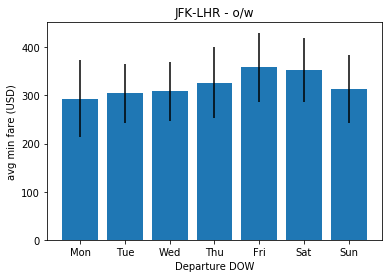

In [66]:
xs = range(7)
plt.bar(xs, dow_summ['avg_min_fare'], yerr=dow_summ['std_min_fare'])
plt.xticks(xs, dow_list);
plt.ylabel("avg min fare (USD)")
plt.xlabel("Departure DOW")
plt.title(f"{market} - o/w");

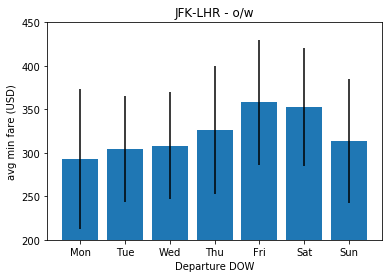

In [65]:
xs = range(7)
plt.bar(xs, dow_summ['avg_min_fare'], yerr=dow_summ['std_min_fare'])
plt.xticks(xs, dow_list);
plt.ylabel("avg min fare (USD)")
plt.xlabel("Departure DOW")
plt.ylim(200, 450)
plt.title(f"{market} - o/w");

/opt/anaconda/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


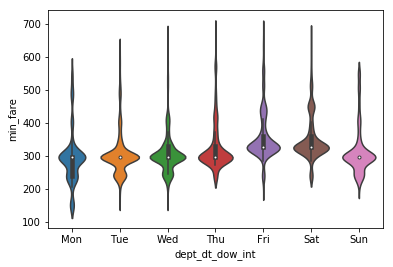

In [67]:
sns.violinplot(data=far_out_df, x='dept_dt_dow_int', y='min_fare');
plt.xticks(range(7), dow_list);

# EDA on +/- 1 dept day

Actually, let's just look back for "prev dept day", regardless of "dow type", and use that info to inform how we define "dow type"

In [73]:
eda_shifted_features_dict = {
    # shift search day -1
    "min_fare_prev_search_day": {
        'sort_col': 'searchDt',
        'groupby_cols': ['outDeptDt', 'inDeptDt']
    },
    # shift departure day +/- 1
    "min_fare_prev_dept_day": {
        'sort_col': 'outDeptDt',
        'groupby_cols': ['searchDt']
    },
    "min_fare_next_dept_day": {
        'sort_col': 'outDeptDt',
        'groupby_cols': ['searchDt'],
        'shift': -1
    },
}

for feature_name, kwargs in eda_shifted_features_dict.items():
    far_out_df[feature_name] = (far_out_df
                    .sort_values(by=kwargs['sort_col'])
                    .groupby(kwargs['groupby_cols'])[target_col]
                    .shift(kwargs.get("shift", 1)) 
                )

dow_shifted_features_dict = {
    # shift departure day +/- 1
    "prev_dept_dow": {
        'sort_col': 'outDeptDt',
        'groupby_cols': ['searchDt']
    },
    "next_dept_dow": {
        'sort_col': 'outDeptDt',
        'groupby_cols': ['searchDt'],
        'shift': -1
    },
}

for feature_name, kwargs in dow_shifted_features_dict.items():
    far_out_df[feature_name] = (far_out_df
                    .sort_values(by=kwargs['sort_col'])
                    .groupby(kwargs['groupby_cols'])['dept_dt_dow']
                    .shift(kwargs.get("shift", 1)) 
                )


dow_shifted_features_dict = {
    # shift departure day +/- 1
    "prev_dept_dow_int": {
        'sort_col': 'outDeptDt',
        'groupby_cols': ['searchDt']
    },
    "next_dept_dow_int": {
        'sort_col': 'outDeptDt',
        'groupby_cols': ['searchDt'],
        'shift': -1
    },
}

for feature_name, kwargs in dow_shifted_features_dict.items():
    far_out_df[feature_name] = (far_out_df
                    .sort_values(by=kwargs['sort_col'])
                    .groupby(kwargs['groupby_cols'])['dept_dt_dow_int']
                    .shift(kwargs.get("shift", 1)) 
                )

In [69]:
# far_out_df = extract_dow_type(far_out_df, 'prev_dept_dow_int')
# far_out_df = extract_dow_type(far_out_df, 'next_dept_dow_int')

prev_dept_dow_type
next_dept_dow_type


In [74]:
far_out_df.head()

,market,origin,destination,round_trip,pos,currency,outDeptDt,inDeptDt,shop_counts,origin_country,origin_city,destination_country,destination_city,outDeptDt_dt,inDeptDt_dt,searchDt_dt,days_til_dept,stay_duration,shop_ind,searchDt,min_fare,train_test,dtd_regime,dept_dt_dow_int,dept_dt_dow,min_fare_prev_search_day,min_fare_prev_dept_day,min_fare_next_dept_day,prev_dept_dow,next_dept_dow,prev_dept_dow_int,next_dept_dow_int
1065362,JFK-LHR,JFK,LHR,0,US,USD,20221230,0,177,US,NYC,GB,LON,2022-12-30,None,2022-09-05,116,NaN,1,20220905,430.40,train,farther_out,4,Fri,430.40,420.9,549.8,Thu,Sun,3.0,6.0
120205,JFK-LHR,JFK,LHR,0,US,USD,20230216,0,296,US,NYC,GB,LON,2023-02-16,None,2022-10-27,112,NaN,1,20221027,296.40,train,farther_out,3,Thu,332.80,252.8,314.4,Wed,Fri,2.0,4.0
842160,JFK-LHR,JFK,LHR,0,US,USD,20230309,0,143,US,NYC,GB,LON,2023-03-09,None,2022-11-12,117,NaN,1,20221112,285.30,train,farther_out,3,Thu,284.60,229.0,309.2,Wed,Fri,2.0,4.0
1456468,JFK-LHR,JFK,LHR,0,US,USD,20221222,0,1151,US,NYC,GB,LON,2022-12-22,None,2022-10-31,52,NaN,1,20221031,582.93,train,farther_out,3,Thu,565.93,664.0,361.6,Wed,Fri,2.0,4.0
657540,JFK-LHR,JFK,LHR,0,US,USD,20221029,0,648,US,NYC,GB,LON,2022-10-29,None,2022-10-01,28,NaN,1,20221001,360.60,train,farther_out,5,Sat,360.60,400.6,401.1,Fri,Sun,4.0,6.0


In [77]:
ex_df = far_out_df[far_out_df['searchDt'] == 20221101]
ex_df.sort_values(by='outDeptDt_dt', inplace=True)
ex_df[['outDeptDt_dt', 'dept_dt_dow', 'min_fare', 
       'prev_dept_dow', 'min_fare_prev_dept_day', ]].head(15)

,outDeptDt_dt,dept_dt_dow,min_fare,prev_dept_dow,min_fare_prev_dept_day
1390138,2022-11-05,Sat,326.6,NaN,NaN
1397086,2022-11-06,Sun,296.4,Sat,326.6
1387846,2022-11-07,Mon,224.8,Sun,296.4
1387563,2022-11-08,Tue,296.4,Mon,224.8
1393233,2022-11-09,Wed,296.4,Tue,296.4
1388554,2022-11-10,Thu,296.4,Wed,296.4
1387775,2022-11-11,Fri,326.4,Thu,296.4
1388736,2022-11-12,Sat,326.4,Fri,326.4
1388083,2022-11-13,Sun,284.8,Sat,326.4
1387533,2022-11-14,Mon,284.4,Sun,284.8


In [80]:
comp_col = 'min_fare_prev_search_day'
df_no_null = far_out_df.dropna(subset=['min_fare', comp_col])
np.corrcoef(df_no_null['min_fare'], df_no_null[comp_col])

array([[1.        , 0.71140191],
       [0.71140191, 1.        ]])

Still correlates well

In [78]:
comp_col = 'min_fare_prev_dept_day'
df_no_null = far_out_df.dropna(subset=['min_fare', comp_col])
np.corrcoef(df_no_null['min_fare'], df_no_null[comp_col])

array([[1.        , 0.57602499],
       [0.57602499, 1.        ]])

In [79]:
comp_col = 'min_fare_next_dept_day'
df_no_null = far_out_df.dropna(subset=['min_fare', comp_col])
np.corrcoef(df_no_null['min_fare'], df_no_null[comp_col])

array([[1.        , 0.57602499],
       [0.57602499, 1.        ]])

There are the same b/c it's essentially a vs b // b vs a

In [81]:
far_out_df['fare_diff_prev_shop_dt'] = far_out_df['min_fare'] - far_out_df['min_fare_prev_search_day']
far_out_df['fare_diff_prev_dept_dt'] = far_out_df['min_fare'] - far_out_df['min_fare_prev_dept_day']

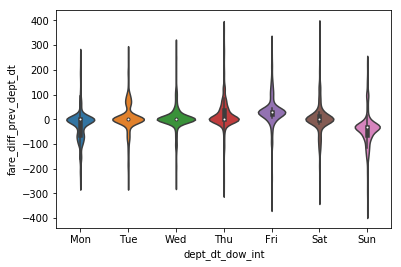

In [82]:
sns.violinplot(data=far_out_df, x='dept_dt_dow_int', y='fare_diff_prev_dept_dt');
plt.xticks(range(7), dow_list);

In [167]:
# not_close_df = mask_df[np.abs(mask_df['fare_diff_prev_dept_dt']) > 50]
# close_df = mask_df[np.abs(mask_df['fare_diff_prev_dept_dt']) <20]

# len(not_close_df), len(close_df)

## plots of individual trips

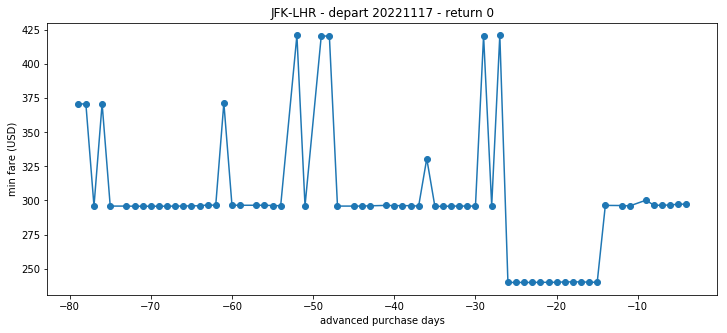

In [83]:
plot_min_fare(far_out_df, 20221117, 0, market)

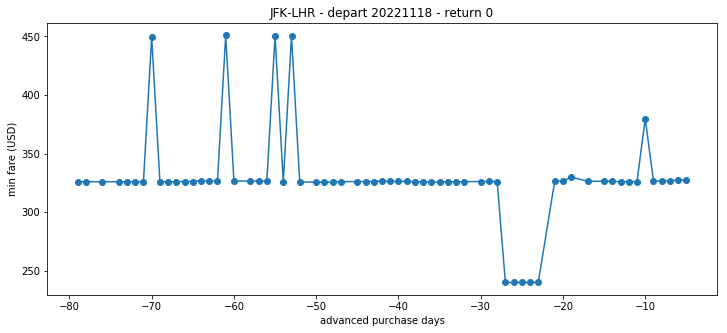

In [84]:
plot_min_fare(far_out_df, 20221118, 0, market)

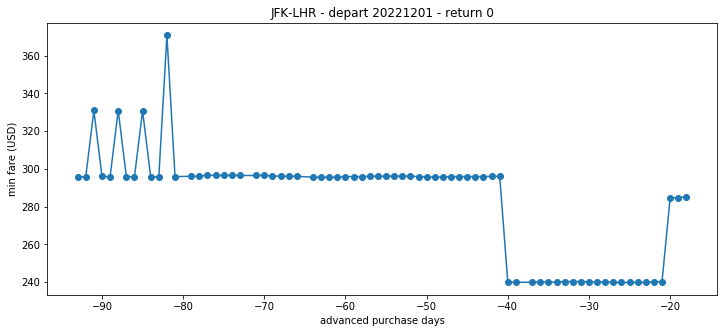

In [85]:
plot_min_fare(far_out_df, 20221201, 0, market)

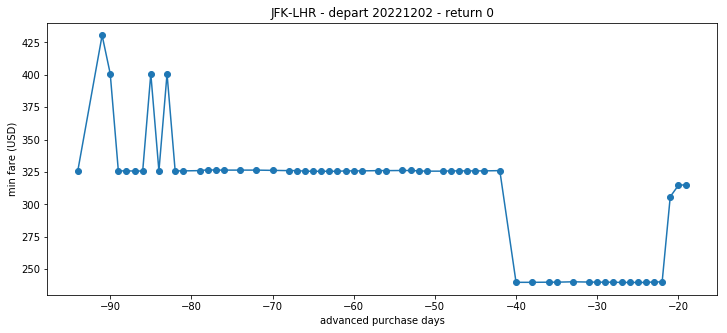

In [86]:
plot_min_fare(far_out_df, 20221202, 0, market)

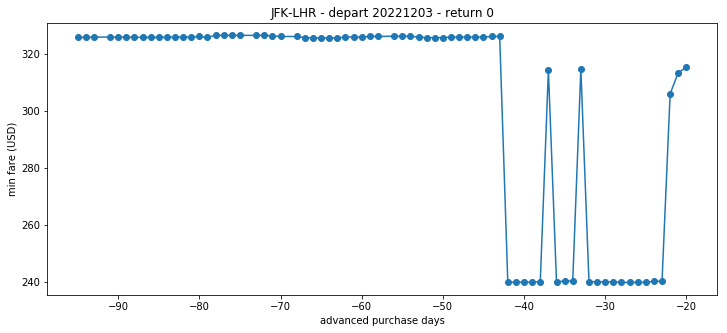

In [87]:
plot_min_fare(far_out_df, 20221203, 0, market)

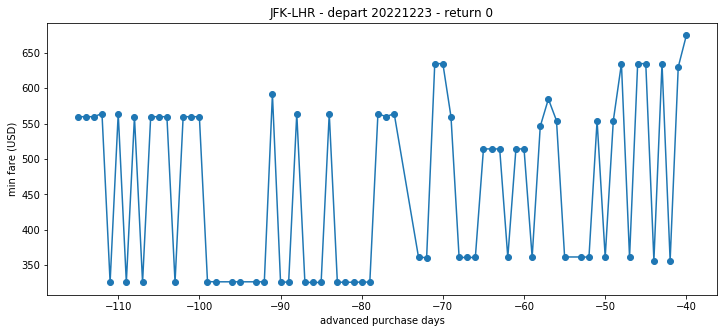

In [88]:
plot_min_fare(far_out_df, 20221223, 0, market)

Holidays are going to be hard to predict -- fares are volatile

## heatmaps

### fares

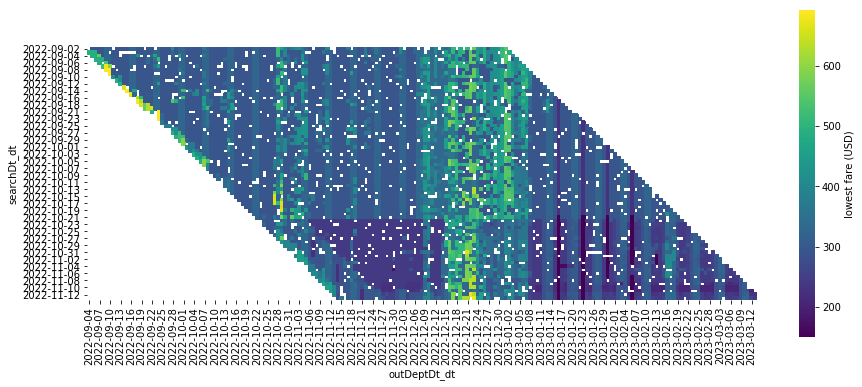

In [90]:
# data *not* filtered by dtd regime
clip_for_plot = clip_ow_df[(clip_ow_df['outDeptDt_dt'] > datetime.date(2022,9,1))
                       &(clip_ow_df['searchDt_dt'] > datetime.date(2022,9,1))]

plt.figure(figsize=(15,12))
pvt_data = clip_for_plot.pivot(index="searchDt_dt", columns="outDeptDt_dt", values="min_fare")
sns.heatmap(pvt_data, cmap='viridis', square=True,
                cbar_kws={'label': 'lowest fare (USD)',
                            'shrink': 0.5,
                            }
                );

### vs. previous shop day

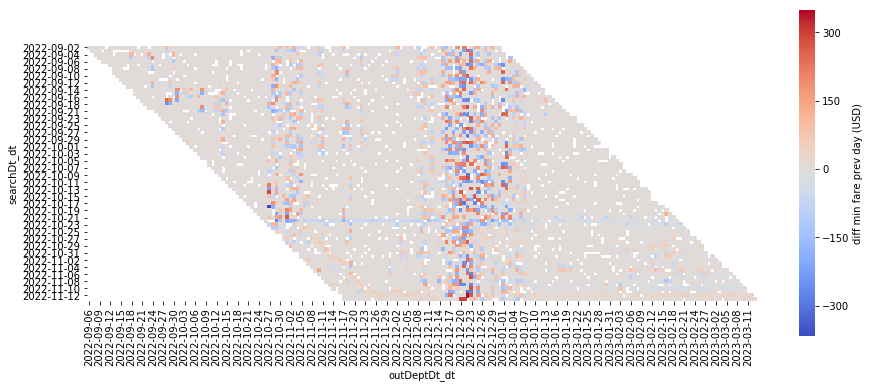

In [91]:
# don't include close-to-departure-date data
clip_for_plot = far_out_df[(far_out_df['outDeptDt_dt'] > datetime.date(2022,9,1))
                       &(far_out_df['searchDt_dt'] > datetime.date(2022,9,1))]
plt.figure(figsize=(15,12))
pvt_data = clip_for_plot.pivot(index="searchDt_dt", columns="outDeptDt_dt", values="fare_diff_prev_shop_dt")
sns.heatmap(pvt_data, cmap='coolwarm', square=True,
                cbar_kws={'label': 'diff min fare prev day (USD)',
                            'shrink': 0.5,
                            }
                );

Boolean: are fares close or not?

In [93]:
far_out_df['fare_prev_shop_dt_close'] = np.where(
    np.isclose(far_out_df['min_fare'], far_out_df['min_fare_prev_search_day'], 0.01), 1, 0)

comp_df = far_out_df.dropna(subset=['min_fare', 'min_fare_prev_search_day'])

In [94]:
comp_df['fare_prev_shop_dt_close'].value_counts(1)

1    0.735622
0    0.264378
Name: fare_prev_shop_dt_close, dtype: float64

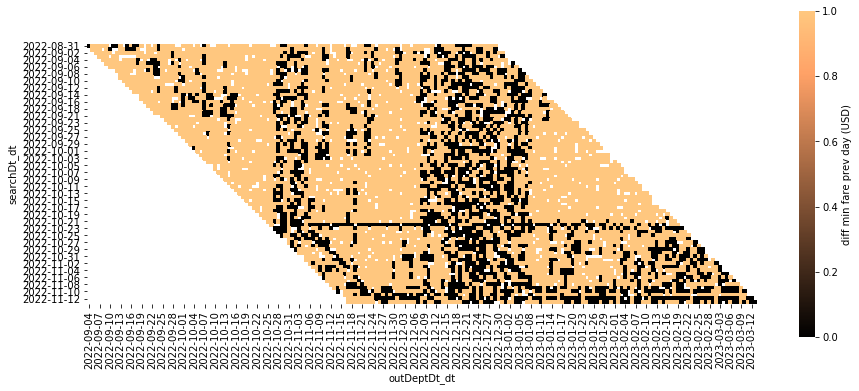

In [95]:
# clip_for_plot = mask_df[(mask_df['outDeptDt_dt'] > datetime.date(2022,9,1))
#                        &(mask_df['searchDt_dt'] > datetime.date(2022,9,1))]
plt.figure(figsize=(15,12))
pvt_data = comp_df.pivot(index="searchDt_dt", columns="outDeptDt_dt", values="fare_prev_shop_dt_close")

sns.heatmap(pvt_data, cmap='copper', square=True,
                cbar_kws={'label': 'diff min fare prev day (USD)',
                            'shrink': 0.5,
                            }
                );

### vs prev dept day

In [ ]:
# computed above:
# mask_df['fare_diff_prev_dept_dt'] = mask_df['min_fare'] - mask_df['min_fare_prev_dept_day']

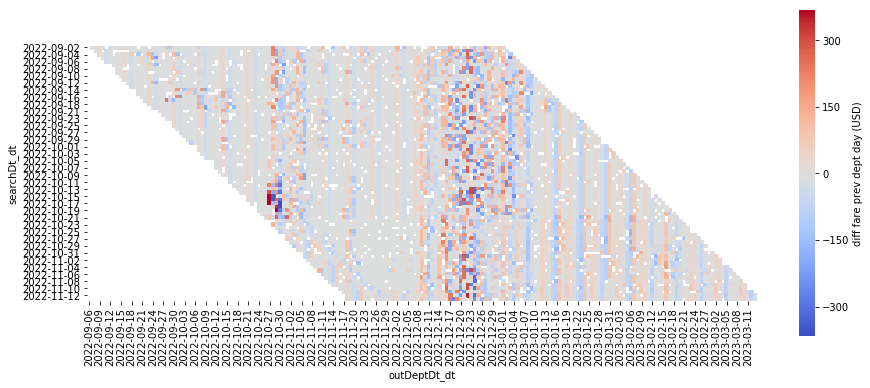

In [96]:
clip_for_plot = far_out_df[(far_out_df['outDeptDt_dt'] > datetime.date(2022,9,1))
                       &(far_out_df['searchDt_dt'] > datetime.date(2022,9,1))]
plt.figure(figsize=(15,12))
pvt_data = clip_for_plot.pivot(index="searchDt_dt", columns="outDeptDt_dt", values="fare_diff_prev_dept_dt")
sns.heatmap(pvt_data, cmap='coolwarm', square=True,
                cbar_kws={'label': 'diff fare prev dept day (USD)',
                            'shrink': 0.5,
                            }
                );

#### Examine by DOW

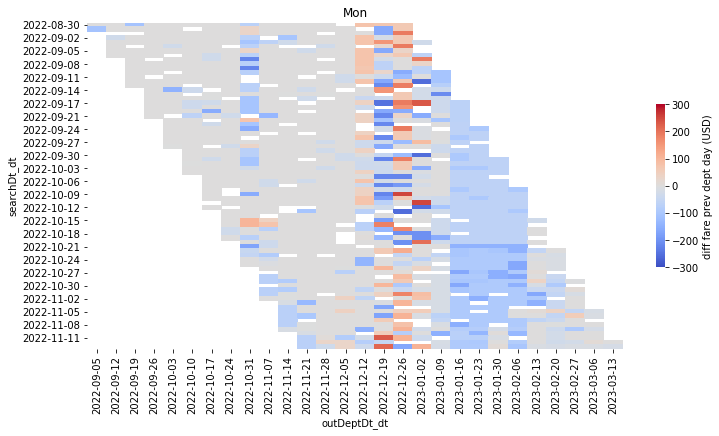

In [97]:
dow = "Mon"
clip_for_plot = far_out_df[(far_out_df['dept_dt_dow'] == dow)]
pvt_data = clip_for_plot.pivot(index="searchDt_dt", columns="outDeptDt_dt", values="fare_diff_prev_dept_dt")
plt.figure(figsize=(12,6))
sns.heatmap(pvt_data, cmap='coolwarm', #square=True,
                cbar_kws={'label': 'diff fare prev dept day (USD)',
                            'shrink': 0.5,},
            vmin=-300, vmax=300);
plt.title(dow);

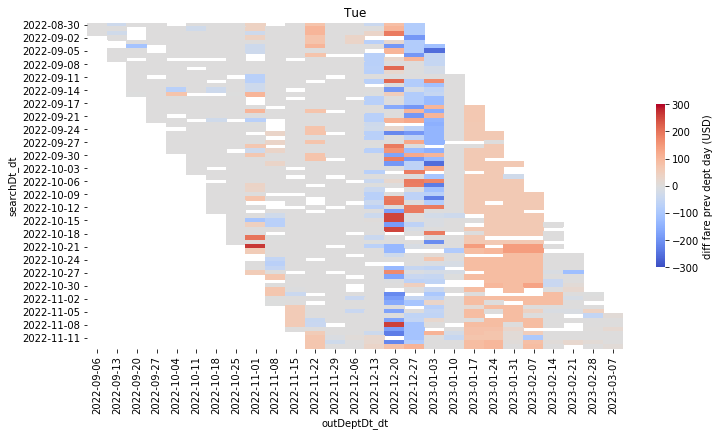

In [98]:
dow = "Tue"
clip_for_plot = far_out_df[(far_out_df['dept_dt_dow'] == dow)]
pvt_data = clip_for_plot.pivot(index="searchDt_dt", columns="outDeptDt_dt", values="fare_diff_prev_dept_dt")
plt.figure(figsize=(12,6))
sns.heatmap(pvt_data, cmap='coolwarm', #square=True,
                cbar_kws={'label': 'diff fare prev dept day (USD)',
                            'shrink': 0.5,},
            vmin=-300, vmax=300);
plt.title(dow);

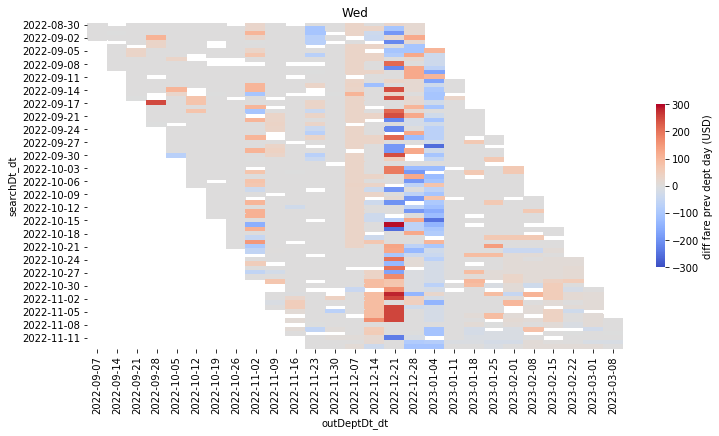

In [99]:
dow = "Wed"
clip_for_plot = far_out_df[(far_out_df['dept_dt_dow'] == dow)]
pvt_data = clip_for_plot.pivot(index="searchDt_dt", columns="outDeptDt_dt", values="fare_diff_prev_dept_dt")
plt.figure(figsize=(12,6))
sns.heatmap(pvt_data, cmap='coolwarm', #square=True,
                cbar_kws={'label': 'diff fare prev dept day (USD)',
                            'shrink': 0.5,},
            vmin=-300, vmax=300);
plt.title(dow);

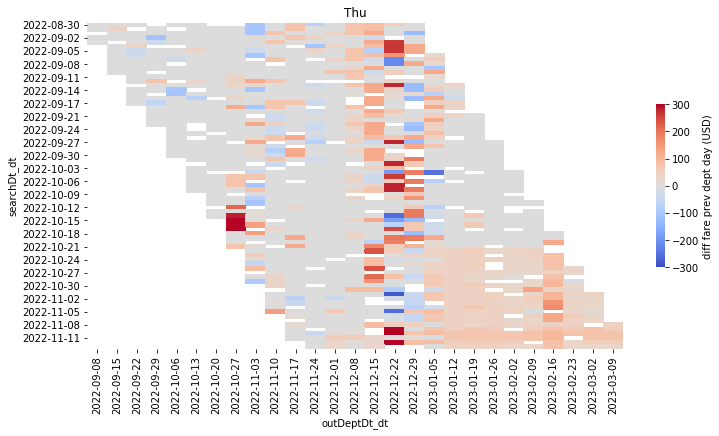

In [100]:
dow = "Thu"
clip_for_plot = far_out_df[(far_out_df['dept_dt_dow'] == dow)]
pvt_data = clip_for_plot.pivot(index="searchDt_dt", columns="outDeptDt_dt", values="fare_diff_prev_dept_dt")
plt.figure(figsize=(12,6))
sns.heatmap(pvt_data, cmap='coolwarm', #square=True,
                cbar_kws={'label': 'diff fare prev dept day (USD)',
                            'shrink': 0.5,},
            vmin=-300, vmax=300);
plt.title(dow);

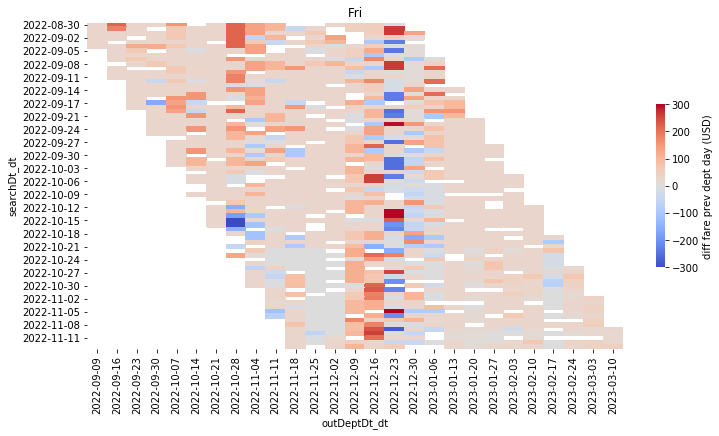

In [101]:
dow = "Fri"
clip_for_plot = far_out_df[(far_out_df['dept_dt_dow'] == dow)]
pvt_data = clip_for_plot.pivot(index="searchDt_dt", columns="outDeptDt_dt", values="fare_diff_prev_dept_dt")
plt.figure(figsize=(12,6))
sns.heatmap(pvt_data, cmap='coolwarm', #square=True,
                cbar_kws={'label': 'diff fare prev dept day (USD)',
                            'shrink': 0.5,},
            vmin=-300, vmax=300);
plt.title(dow);

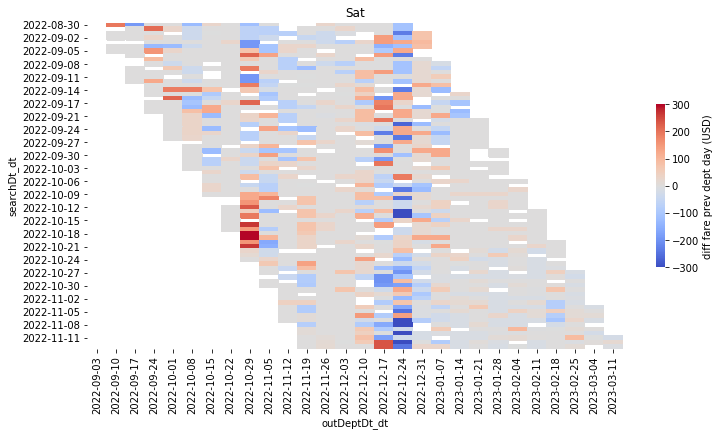

In [102]:
dow = "Sat"
clip_for_plot = far_out_df[(far_out_df['dept_dt_dow'] == dow)]
pvt_data = clip_for_plot.pivot(index="searchDt_dt", columns="outDeptDt_dt", values="fare_diff_prev_dept_dt")
plt.figure(figsize=(12,6))
sns.heatmap(pvt_data, cmap='coolwarm', #square=True,
                cbar_kws={'label': 'diff fare prev dept day (USD)',
                            'shrink': 0.5,},
            vmin=-300, vmax=300);
plt.title(dow);

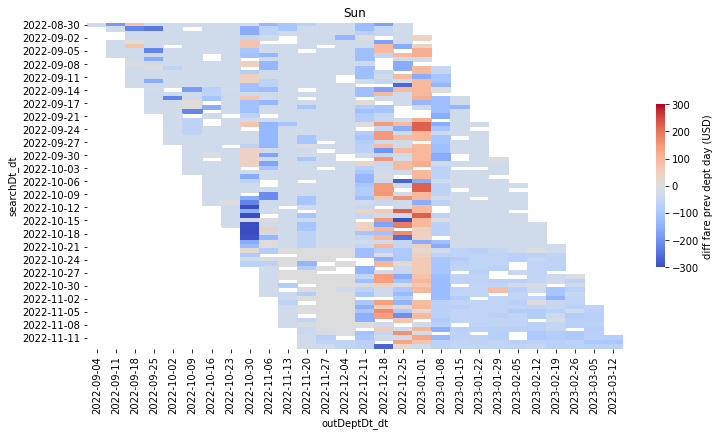

In [103]:
dow = "Sun"
clip_for_plot = far_out_df[(far_out_df['dept_dt_dow'] == dow)]
pvt_data = clip_for_plot.pivot(index="searchDt_dt", columns="outDeptDt_dt", values="fare_diff_prev_dept_dt")
plt.figure(figsize=(12,6))
sns.heatmap(pvt_data, cmap='coolwarm', #square=True,
                cbar_kws={'label': 'diff fare prev dept day (USD)',
                            'shrink': 0.5,},
            vmin=-300, vmax=300);
plt.title(dow);

### conclusion (?)

For some DOW's, the difference between prev dept day appears to be consistent across a departure day
- so: feature(s) we should engineer & pull forward is/are: 
    - prev fare diff + prev day fare
    - median prev fare diff (last 3 days) + median prev day fare (last 3 days)

In [104]:
far_out_df['shifted_fare_diff_prev_dd'] = (far_out_df
                                        .sort_values(by=['searchDt'])
                                        .groupby(['outDeptDt'])['fare_diff_prev_dept_dt']
                                        .shift(1)
                                       )
far_out_df['calc_fare_from_prev_dd'] = far_out_df['min_fare_prev_dept_day'] + far_out_df['shifted_fare_diff_prev_dd']

In [106]:
ex_df = far_out_df[far_out_df['outDeptDt'] == 20221105]
ex_df.sort_values(by='searchDt_dt', inplace=True)
ex_df[['searchDt_dt', 'dept_dt_dow', 'dtd_regime', 'min_fare', 'min_fare_prev_dept_day', 'fare_diff_prev_dept_dt', 
       'shifted_fare_diff_prev_dd', 'calc_fare_from_prev_dd']].head(15)

,searchDt_dt,dept_dt_dow,dtd_regime,min_fare,min_fare_prev_dept_day,fare_diff_prev_dept_dt,shifted_fare_diff_prev_dd,calc_fare_from_prev_dd
1184110,2022-08-30,Sat,farther_out,430.3,430.3,0.0,NaN,NaN
491133,2022-08-31,Sat,farther_out,360.9,430.3,-69.4,0.0,430.3
1179848,2022-09-01,Sat,farther_out,361.0,430.4,-69.4,-69.4,361.0
1342976,2022-09-02,Sat,farther_out,326.0,361.0,-35.0,-69.4,291.6
36809,2022-09-04,Sat,farther_out,325.9,430.4,-104.5,-35.0,395.4
1064230,2022-09-05,Sat,farther_out,325.9,430.4,-104.5,-104.5,325.9
1407732,2022-09-06,Sat,farther_out,430.3,295.9,134.4,-104.5,191.4
767665,2022-09-07,Sat,farther_out,325.8,325.8,0.0,134.4,460.2
328288,2022-09-08,Sat,farther_out,430.3,430.3,0.0,0.0,430.3
558785,2022-09-09,Sat,farther_out,430.3,430.3,0.0,0.0,430.3


In [105]:
comp_df = far_out_df.dropna(subset=['min_fare', 'calc_fare_from_prev_dd'])
np.corrcoef(comp_df['min_fare'], comp_df['calc_fare_from_prev_dd'])

array([[1.        , 0.59301685],
       [0.59301685, 1.        ]])

I wonder how much Holiday volatility is contributing to this

In [110]:
holiday_start = datetime.date(2022,12,16)
holiday_end = datetime.date(2023,1,3)
not_holiday_df = far_out_df[
    (far_out_df['outDeptDt_dt'] < holiday_start) | (far_out_df['outDeptDt_dt'] > holiday_end)
]

In [111]:
not_holiday_df.head()

,market,origin,destination,round_trip,pos,currency,outDeptDt,inDeptDt,shop_counts,origin_country,origin_city,destination_country,destination_city,outDeptDt_dt,inDeptDt_dt,searchDt_dt,days_til_dept,stay_duration,shop_ind,searchDt,min_fare,train_test,dtd_regime,dept_dt_dow_int,dept_dt_dow,min_fare_prev_search_day,min_fare_prev_dept_day,min_fare_next_dept_day,prev_dept_dow,next_dept_dow,prev_dept_dow_int,next_dept_dow_int,fare_diff_prev_shop_dt,fare_diff_prev_dept_dt,fare_prev_shop_dt_close,shifted_fare_diff_prev_dd,calc_fare_from_prev_dd
120205,JFK-LHR,JFK,LHR,0,US,USD,20230216,0,296,US,NYC,GB,LON,2023-02-16,None,2022-10-27,112,NaN,1,20221027,296.4,train,farther_out,3,Thu,332.8,252.8,314.4,Wed,Fri,2.0,4.0,-36.4,43.6,0,80.0,332.8
842160,JFK-LHR,JFK,LHR,0,US,USD,20230309,0,143,US,NYC,GB,LON,2023-03-09,None,2022-11-12,117,NaN,1,20221112,285.3,train,farther_out,3,Thu,284.6,229.0,309.2,Wed,Fri,2.0,4.0,0.7,56.3,1,77.6,306.6
657540,JFK-LHR,JFK,LHR,0,US,USD,20221029,0,648,US,NYC,GB,LON,2022-10-29,None,2022-10-01,28,NaN,1,20221001,360.6,train,farther_out,5,Sat,360.6,400.6,401.1,Fri,Sun,4.0,6.0,0.0,-40.0,1,35.0,435.6
1133702,JFK-LHR,JFK,LHR,0,US,USD,20221206,0,358,US,NYC,GB,LON,2022-12-06,None,2022-10-02,65,NaN,1,20221002,295.9,train,farther_out,1,Tue,295.6,295.9,330.9,Mon,Wed,0.0,2.0,0.3,0.0,1,0.0,295.9
1456866,JFK-LHR,JFK,LHR,0,US,USD,20221115,0,1575,US,NYC,GB,LON,2022-11-15,None,2022-10-31,15,NaN,1,20221031,240.3,train,farther_out,1,Tue,240.3,243.8,240.3,Mon,Wed,0.0,2.0,0.0,-3.5,1,0.0,243.8


Technically, should go back & recalculate features, but for now...

In [113]:
comp_df = not_holiday_df.dropna(subset=['min_fare', 'calc_fare_from_prev_dd'])
print(len(comp_df))
np.corrcoef(comp_df['min_fare'], comp_df['calc_fare_from_prev_dd'])

6399


array([[1.        , 0.67292467],
       [0.67292467, 1.        ]])

Better!